In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from gensim import models
from gensim.models import KeyedVectors
import wordcloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prakharkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data:

In [2]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


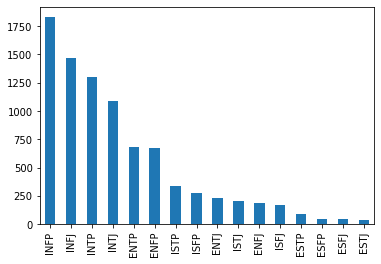

In [7]:
df["type"].value_counts().plot(kind='bar')
plt.show()

# Formatting the data:

In [8]:
# Create indicator target variables.
df["IvsE"] = df["type"].apply(lambda x: 1 if x[0] == "I" else 0)
df["NvsS"] = df["type"].apply(lambda x: 1 if x[1] == "N" else 0)
df["TvsF"] = df["type"].apply(lambda x: 1 if x[2] == "T" else 0)
df["JvsP"] = df["type"].apply(lambda x: 1 if x[3] == "J" else 0)

In [10]:
# convert to lower case.
df["clean_posts"] = df["posts"].str.lower()

# sentences are seperated by |||, replace them with space
df["clean_posts"] = df["clean_posts"].str.replace(re.compile(r"\|\|\|"), " ")

# remove links, urls.
df["clean_posts"] = df["clean_posts"].str.replace(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), "")

# dropping emails
df["clean_posts"] = df["clean_posts"].str.replace(re.compile(r"\S+@\S+"), "")

# dropping punctuations
df["clean_posts"] = df["clean_posts"].str.replace(re.compile(r"[^a-z\s]"), " ")

# dropping MBTIs mentioned in the posts. There are quite a few mention of these types in these posts.
mbtiTypes = df["type"].unique()
for type_word in mbtiTypes:
    df["clean_posts"] = df["clean_posts"].str.replace(type_word.lower(), "")

In [14]:
# Lemmatize the text.
lemmatizer = WordNetLemmatizer()

df["clean_posts"] = df["clean_posts"].apply(
    lambda x: " ".join(
        [
            lemmatizer.lemmatize(word)
            for word in x.split(" ")
            if word not in stopwords.words("english")
        ]
    )
)

In [15]:
# Remove words of length 2 or less.
df["clean_posts"] = df["clean_posts"].str.replace(re.compile(r"\b\w{1,2}\b"), "")

In [17]:
df.to_csv('FormattedCSV.csv', index=False)

In [2]:
df = pd.read_csv('FormattedCSV.csv')

In [3]:
df.head()

,type,posts,IvsE,NvsS,TvsF,JvsP,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1,fired another silly misconception approachi...


# Feature Engineering:

##### TFIDF:

In [4]:
cVect = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1)

In [5]:
X_countVect = cVect.fit_transform(df['clean_posts'])

In [6]:
tfidfVect = TfidfTransformer()
X_tfidf =  tfidfVect.fit_transform(X_countVect).toarray()

##### Word2Vec:

In [7]:
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
X_w2v = []
for post in df['clean_posts']:
    wdim = np.zeros(300)
    for token in post.strip().split(" "):
        try:
            wdim += w2v[token]
        except:
            pass
    wdim /= len(post.strip().split(" "))
    X_w2v.append(wdim)

##### Glove:

In [4]:
tmp = pd.read_csv('glove.840B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in tmp.T.items()}

In [6]:
X_glove = []
for post in df['clean_posts']:
    wdim = np.zeros(300)
    for token in post.strip().split(" "):
        try:
            wdim += glove[token]
        except:
            pass
    wdim /= len(post.strip().split(" "))
    X_glove.append(wdim)

In [8]:
targets = ['IvsE', 'NvsS', 'TvsF', 'JvsP']

## Logistic Regression:

### TFIDF:

In [10]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10]
for c in c_values:
    print("C =", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        lrClf = LogisticRegression(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df[t], test_size=0.3, random_state=0)
        lrClf.fit(X_train, y_train)
        y_pred = lrClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = lrClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C = 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accurac

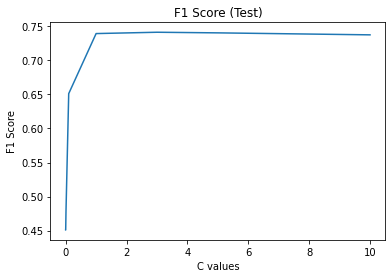

In [11]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.show()

In [12]:
print(bestF1Avg)

0.7415180217660655


### Word2Vec:

In [13]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10]
for c in c_values:
    print("C =", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        lrClf = LogisticRegression(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_w2v, df[t], test_size=0.3, random_state=0)
        lrClf.fit(X_train, y_train)
        y_pred = lrClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = lrClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C = 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accurac

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TvsF  F1 Score ->  0.7292020373514431  Accuracy Score ->  0.7548981943910872
JvsP  F1 Score ->  0.38038436050364477  Accuracy Score ->  0.6407990779869381




/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


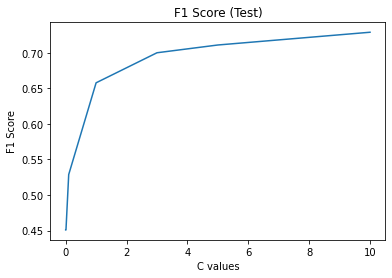

In [14]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.show()

In [15]:
print(bestF1Avg)

0.7289513446755103


### Glove:

In [9]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10]
for c in c_values:
    print("C =", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        lrClf = LogisticRegression(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_glove, df[t], test_size=0.3, random_state=0)
        lrClf.fit(X_train, y_train)
        y_pred = lrClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = lrClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C = 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C = 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accurac

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


IvsE  F1 Score ->  0.8739054290718038  Accuracy Score ->  0.7787168651555897


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NvsS  F1 Score ->  0.9305870236869207  Accuracy Score ->  0.8705339992316558


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TvsF  F1 Score ->  0.7259512612227447  Accuracy Score ->  0.7537456780637726


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


JvsP  F1 Score ->  0.3846653671215075  Accuracy Score ->  0.6361890126776796


C = 5


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


IvsE  F1 Score ->  0.8744493392070486  Accuracy Score ->  0.781021897810219


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NvsS  F1 Score ->  0.9303092783505156  Accuracy Score ->  0.870149827122551


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TvsF  F1 Score ->  0.7294418406476354  Accuracy Score ->  0.7560507107184018


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


JvsP  F1 Score ->  0.4078282828282828  Accuracy Score ->  0.6396465616596235


C = 10


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


IvsE  F1 Score ->  0.875139105274872  Accuracy Score ->  0.7844794467921629


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NvsS  F1 Score ->  0.9315691544345669  Accuracy Score ->  0.8728390318862851


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TvsF  F1 Score ->  0.7319148936170212  Accuracy Score ->  0.7579715712639262
JvsP  F1 Score ->  0.4324324324324324  Accuracy Score ->  0.6450249711870918




/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


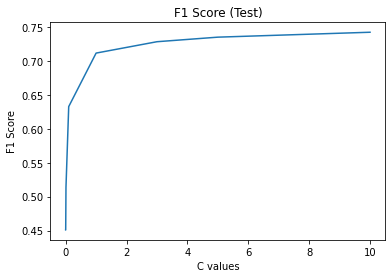

In [10]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.show()

In [11]:
print(bestF1Avg)

0.7427638964397232


## Decision Trees:

### TFIDF:

In [16]:
bestF1Avg = 0
bestComb = {}
f1s = []
md = [3, 5, 6, 7, 9, 15, 21]
for d in md:
    print("Max depth:", d)
    avgF1 = 0
    comb = {}
    for t in targets:
        dtClf = DecisionTreeClassifier(random_state=0, max_depth=d)
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df[t], test_size=0.3, random_state=0)
        dtClf.fit(X_train, y_train)
        y_pred = dtClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = dtClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Max depth: 3
IvsE  F1 Score ->  0.8637566137566138  Accuracy Score ->  0.7625816365731848
NvsS  F1 Score ->  0.9271413828689371  Accuracy Score ->  0.8643872454859777
TvsF  F1 Score ->  0.6255411255411256  Accuracy Score ->  0.6012293507491356
JvsP  F1 Score ->  0.24655547498187094  Accuracy Score ->  0.6008451786400307


Max depth: 5
IvsE  F1 Score ->  0.8581655480984341  Accuracy Score ->  0.7564348828275067
NvsS  F1 Score ->  0.9264158743282348  Accuracy Score ->  0.8632347291586631
TvsF  F1 Score ->  0.6039215686274508  Accuracy Score ->  0.6119861698040723
JvsP  F1 Score ->  0.24233983286908076  Accuracy Score ->  0.5820207452938917


Max depth: 6
IvsE  F1 Score ->  0.8511216859279401  Accuracy Score ->  0.7475989243180945
NvsS  F1 Score ->  0.9229491173416406  Accuracy Score ->  0.8574721475220899
TvsF  F1 Score ->  0.5893642542982808  Accuracy Score ->  0.6054552439492893
JvsP  F1 Score ->  0.22881355932203393  Accuracy Score ->  0.5804840568574722


Max depth: 7
IvsE  F1 Score 

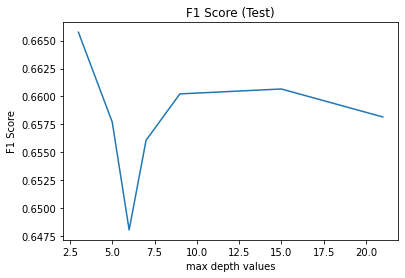

In [17]:
plt.title("F1 Score (Test)")
plt.plot(md, f1s)
plt.xlabel('max depth values')
plt.ylabel('F1 Score')
plt.show()

In [18]:
print(bestF1Avg)

0.6657486492871368


### Word2Vec:

In [19]:
bestF1Avg = 0
bestComb = {}
f1s = []
md = [3, 5, 6, 7, 9, 15, 21]
for d in md:
    print("Max depth:", d)
    avgF1 = 0
    comb = {}
    for t in targets:
        dtClf = DecisionTreeClassifier(random_state=0, max_depth=d)
        X_train, X_test, y_train, y_test = train_test_split(X_w2v, df[t], test_size=0.3, random_state=0)
        dtClf.fit(X_train, y_train)
        y_pred = dtClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = dtClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Max depth: 3
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9242895664799834  Accuracy Score ->  0.8597771801767192
TvsF  F1 Score ->  0.6309121621621622  Accuracy Score ->  0.6642335766423357
JvsP  F1 Score ->  0.4162844036697248  Accuracy Score ->  0.6089127929312332


Max depth: 5
IvsE  F1 Score ->  0.8643769264641128  Accuracy Score ->  0.7633499807913946
NvsS  F1 Score ->  0.9228845352230095  Accuracy Score ->  0.8578563196311948
TvsF  F1 Score ->  0.6069027341999104  Accuracy Score ->  0.6630810603150211
JvsP  F1 Score ->  0.4050487664945496  Accuracy Score ->  0.6016135228582405


Max depth: 6
IvsE  F1 Score ->  0.8568872987477638  Accuracy Score ->  0.7541298501728775
NvsS  F1 Score ->  0.9219206680584552  Accuracy Score ->  0.8563196311947753
TvsF  F1 Score ->  0.6072224699063754  Accuracy Score ->  0.6615443718786016
JvsP  F1 Score ->  0.40628507295173955  Accuracy Score ->  0.593545908567038


Max depth: 7
IvsE  F1 Score -> 

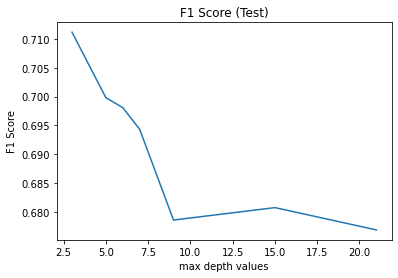

In [20]:
plt.title("F1 Score (Test)")
plt.plot(md, f1s)
plt.xlabel('max depth values')
plt.ylabel('F1 Score')
plt.show()

In [21]:
print(bestF1Avg)

0.7111615763680109


### Glove:

In [12]:
bestF1Avg = 0
bestComb = {}
f1s = []
md = [3, 5, 6, 7, 9, 15, 21]
for d in md:
    print("Max depth:", d)
    avgF1 = 0
    comb = {}
    for t in targets:
        dtClf = DecisionTreeClassifier(random_state=0, max_depth=d)
        X_train, X_test, y_train, y_test = train_test_split(X_glove, df[t], test_size=0.3, random_state=0)
        dtClf.fit(X_train, y_train)
        y_pred = dtClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = dtClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Max depth: 3
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9255958549222798  Accuracy Score ->  0.8620822128313484
TvsF  F1 Score ->  0.614743856726364  Accuracy Score ->  0.644640799077987
JvsP  F1 Score ->  0.34900990099009904  Accuracy Score ->  0.5958509412216673


Max depth: 5
IvsE  F1 Score ->  0.8591172536781096  Accuracy Score ->  0.7572032270457165
NvsS  F1 Score ->  0.9190545910897302  Accuracy Score ->  0.8513253937764118
TvsF  F1 Score ->  0.6349079263410728  Accuracy Score ->  0.6496350364963503
JvsP  F1 Score ->  0.3801749271137027  Accuracy Score ->  0.5916250480215136


Max depth: 6
IvsE  F1 Score ->  0.8502857142857144  Accuracy Score ->  0.7483672685363043
NvsS  F1 Score ->  0.9194630872483222  Accuracy Score ->  0.8524779101037264
TvsF  F1 Score ->  0.6407846342460155  Accuracy Score ->  0.6623127160968114
JvsP  F1 Score ->  0.4172506738544474  Accuracy Score ->  0.5847099500576258


Max depth: 7
IvsE  F1 Score ->  

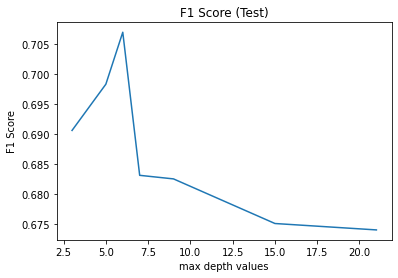

In [13]:
plt.title("F1 Score (Test)")
plt.plot(md, f1s)
plt.xlabel('max depth values')
plt.ylabel('F1 Score')
plt.show()

In [14]:
print(bestF1Avg)

0.7069460274086249


## Random Forests:

### TFIDF:

In [22]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for est in n_estims:
    print("n_estimators:", est)
    avgF1 = 0
    comb = {}
    for t in targets:
        rfClf = RandomForestClassifier(random_state=0, n_estimators=est)
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df[t], test_size=0.3, random_state=0)
        rfClf.fit(X_train, y_train)
        y_pred = rfClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = rfClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

n_estimators: 50
IvsE  F1 Score ->  0.8725617685305591  Accuracy Score ->  0.7741067998463311
NvsS  F1 Score ->  0.9303186022610483  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.5938534278959811  Accuracy Score ->  0.6699961582789089
JvsP  F1 Score ->  0.19999999999999998  Accuracy Score ->  0.6004610065309258


n_estimators: 100
IvsE  F1 Score ->  0.8729162156310891  Accuracy Score ->  0.774490971955436
NvsS  F1 Score ->  0.9303186022610483  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.638655462184874  Accuracy Score ->  0.7026507875528236
JvsP  F1 Score ->  0.15397215397215397  Accuracy Score ->  0.60315021129466


n_estimators: 150
IvsE  F1 Score ->  0.8729162156310891  Accuracy Score ->  0.774490971955436
NvsS  F1 Score ->  0.9303186022610483  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.6448641179180101  Accuracy Score ->  0.7038033038801383
JvsP  F1 Score ->  0.13717188823031326  Accuracy Score ->  0.6085286208221283


n_estimators: 200
IvsE

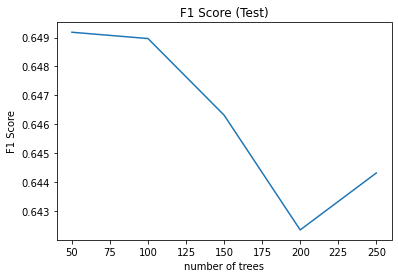

In [23]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('number of trees')
plt.ylabel('F1 Score')
plt.show()

In [24]:
print(bestF1Avg)

0.6491834496718971


### Word2Vec:

In [25]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for est in n_estims:
    print("n_estimators:", est)
    avgF1 = 0
    comb = {}
    for t in targets:
        rfClf = RandomForestClassifier(random_state=0, n_estimators=est)
        X_train, X_test, y_train, y_test = train_test_split(X_w2v, df[t], test_size=0.3, random_state=0)
        rfClf.fit(X_train, y_train)
        y_pred = rfClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = rfClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

n_estimators: 50
IvsE  F1 Score ->  0.8711656441717792  Accuracy Score ->  0.7741067998463311
NvsS  F1 Score ->  0.9270208807111847  Accuracy Score ->  0.8643872454859777
TvsF  F1 Score ->  0.6734065934065934  Accuracy Score ->  0.7145601229350749
JvsP  F1 Score ->  0.3238221632382216  Accuracy Score ->  0.6085286208221283


n_estimators: 100
IvsE  F1 Score ->  0.8729882557633754  Accuracy Score ->  0.7756434882827506
NvsS  F1 Score ->  0.9283501961594053  Accuracy Score ->  0.866692278140607
TvsF  F1 Score ->  0.6821569487067075  Accuracy Score ->  0.7214752208989628
JvsP  F1 Score ->  0.3497997329773031  Accuracy Score ->  0.6258163657318478


n_estimators: 150
IvsE  F1 Score ->  0.8725298588490771  Accuracy Score ->  0.774490971955436
NvsS  F1 Score ->  0.9292929292929292  Accuracy Score ->  0.8682289665770265
TvsF  F1 Score ->  0.6960313999127781  Accuracy Score ->  0.7322320399538993
JvsP  F1 Score ->  0.32926829268292684  Accuracy Score ->  0.6196696119861698


n_estimators: 200


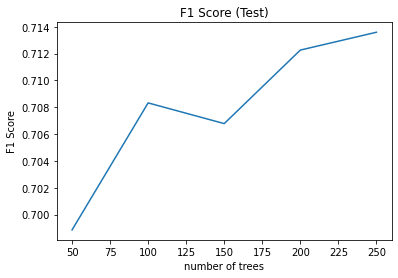

In [26]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('number of trees')
plt.ylabel('F1 Score')
plt.show()

In [27]:
print(bestF1Avg)

0.7135924508035967


### Glove:

In [15]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for est in n_estims:
    print("n_estimators:", est)
    avgF1 = 0
    comb = {}
    for t in targets:
        rfClf = RandomForestClassifier(random_state=0, n_estimators=est)
        X_train, X_test, y_train, y_test = train_test_split(X_glove, df[t], test_size=0.3, random_state=0)
        rfClf.fit(X_train, y_train)
        y_pred = rfClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = rfClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

n_estimators: 50
IvsE  F1 Score ->  0.8682306511729884  Accuracy Score ->  0.7691125624279678
NvsS  F1 Score ->  0.9287042777433353  Accuracy Score ->  0.8674606223588167
TvsF  F1 Score ->  0.6836108676599474  Accuracy Score ->  0.7226277372262774
JvsP  F1 Score ->  0.3103678929765887  Accuracy Score ->  0.6039185555128698


n_estimators: 100
IvsE  F1 Score ->  0.8709677419354839  Accuracy Score ->  0.7725701114099116
NvsS  F1 Score ->  0.9281881964506808  Accuracy Score ->  0.8663081060315021
TvsF  F1 Score ->  0.6965131295738269  Accuracy Score ->  0.7291586630810604
JvsP  F1 Score ->  0.3073798239675017  Accuracy Score ->  0.6069919323857088


n_estimators: 150
IvsE  F1 Score ->  0.8705882352941177  Accuracy Score ->  0.7718017671917019
NvsS  F1 Score ->  0.9292053663570691  Accuracy Score ->  0.8682289665770265
TvsF  F1 Score ->  0.70198105081826  Accuracy Score ->  0.7341529004994237
JvsP  F1 Score ->  0.3041095890410959  Accuracy Score ->  0.6096811371494429


n_estimators: 200
I

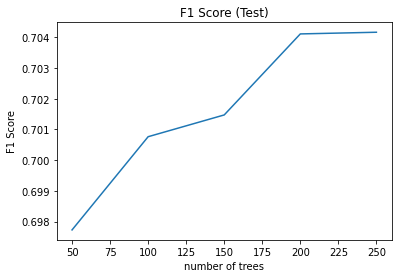

In [16]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('number of trees')
plt.ylabel('F1 Score')
plt.show()

In [17]:
print(bestF1Avg)

0.7041625830751638


## SVC:

### TFIDF:

In [28]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
for c in c_values:
    print("C:", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        svcClf = SVC(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df[t], test_size=0.3, random_state=0)
        svcClf.fit(X_train, y_train)
        y_pred = svcClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = svcClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C: 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Sc

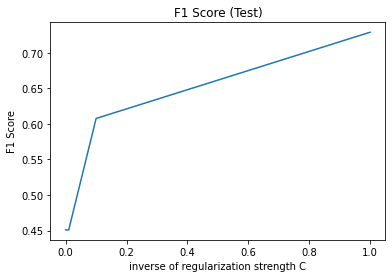

In [29]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('inverse of regularization strength C')
plt.ylabel('F1 Score')
plt.show()

In [30]:
print(bestF1Avg)

0.7291251523377031


### Word2Vec:

In [31]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
for c in c_values:
    print("C:", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        svcClf = SVC(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_w2v, df[t], test_size=0.3, random_state=0)
        svcClf.fit(X_train, y_train)
        y_pred = svcClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = svcClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C: 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Sc

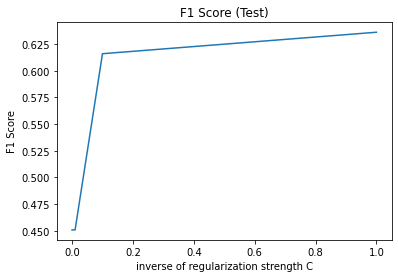

In [32]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('inverse of regularization strength C')
plt.ylabel('F1 Score')
plt.show()

In [33]:
print(bestF1Avg)

0.6360198160767057


### Glove:

In [18]:
bestF1Avg = 0
bestComb = {}
f1s = []
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
for c in c_values:
    print("C:", c)
    avgF1 = 0
    comb = {}
    for t in targets:
        svcClf = SVC(random_state=0, C=c)
        X_train, X_test, y_train, y_test = train_test_split(X_glove, df[t], test_size=0.3, random_state=0)
        svcClf.fit(X_train, y_train)
        y_pred = svcClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = svcClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

C: 1e-05
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.0001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.001
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Score ->  0.869765655013446
TvsF  F1 Score ->  0.0  Accuracy Score ->  0.5409143296196696
JvsP  F1 Score ->  0.0  Accuracy Score ->  0.5950825970034576


C: 0.01
IvsE  F1 Score ->  0.8731601731601731  Accuracy Score ->  0.7748751440645409
NvsS  F1 Score ->  0.9303472364906513  Accuracy Sc

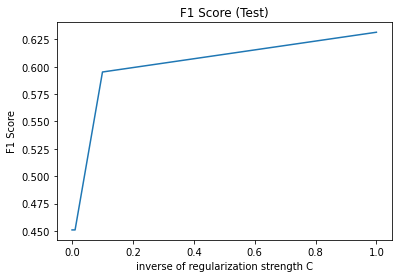

In [19]:
plt.title("F1 Score (Test)")
plt.plot(c_values, f1s)
plt.xlabel('inverse of regularization strength C')
plt.ylabel('F1 Score')
plt.show()

In [20]:
print(bestF1Avg)

0.6315509138461533


## XGBoost:

### TFIDF:

In [34]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for estim in n_estims:
    print("Boosting rounds:", estim)
    avgF1 = 0
    comb = {}
    for t in targets:
        xgbClf = XGBClassifier(use_label_encoder=False, random_state=0, eval_metric='mlogloss', n_estimators=estim)
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df[t], test_size=0.3, random_state=0)
        xgbClf.fit(X_train, y_train)
        y_pred = xgbClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = xgbClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Boosting rounds: 50
IvsE  F1 Score ->  0.8656382740889784  Accuracy Score ->  0.7691125624279678
NvsS  F1 Score ->  0.9273027674514664  Accuracy Score ->  0.8647714175950826
TvsF  F1 Score ->  0.6683501683501684  Accuracy Score ->  0.6972723780253554
JvsP  F1 Score ->  0.38654503990877986  Accuracy Score ->  0.5866308106031503


Boosting rounds: 100
IvsE  F1 Score ->  0.8629737609329446  Accuracy Score ->  0.7652708413369189
NvsS  F1 Score ->  0.9282474226804124  Accuracy Score ->  0.8663081060315021
TvsF  F1 Score ->  0.6709346991037132  Accuracy Score ->  0.7038033038801383
JvsP  F1 Score ->  0.40434037692747005  Accuracy Score ->  0.5993084902036112


Boosting rounds: 150
IvsE  F1 Score ->  0.8638708230544966  Accuracy Score ->  0.7668075297733384
NvsS  F1 Score ->  0.9273027674514664  Accuracy Score ->  0.8647714175950826
TvsF  F1 Score ->  0.678969957081545  Accuracy Score ->  0.7126392623895506
JvsP  F1 Score ->  0.40689655172413797  Accuracy Score ->  0.6035343834037649


Boosti

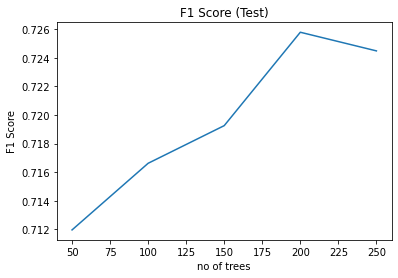

In [35]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('no of trees')
plt.ylabel('F1 Score')
plt.show()

In [36]:
print(bestF1Avg)

0.7257982044764366


### Word2Vec:

In [37]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for estim in n_estims:
    print("Boosting rounds:", estim)
    avgF1 = 0
    comb = {}
    for t in targets:
        xgbClf = XGBClassifier(use_label_encoder=False, random_state=0, eval_metric='mlogloss', n_estimators=estim)
        X_train, X_test, y_train, y_test = train_test_split(np.array(X_w2v), df[t], test_size=0.3, random_state=0)
        xgbClf.fit(X_train, y_train)
        y_pred = xgbClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = xgbClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Boosting rounds: 50
IvsE  F1 Score ->  0.8634520054078414  Accuracy Score ->  0.7671917018824433
NvsS  F1 Score ->  0.9286307053941908  Accuracy Score ->  0.8678447944679216
TvsF  F1 Score ->  0.7097591888466414  Accuracy Score ->  0.7360737610449481
JvsP  F1 Score ->  0.4524590163934426  Accuracy Score ->  0.6150595466769112


Boosting rounds: 100
IvsE  F1 Score ->  0.862418374240036  Accuracy Score ->  0.7652708413369189
NvsS  F1 Score ->  0.9292971179763633  Accuracy Score ->  0.8689973107952362
TvsF  F1 Score ->  0.7226185480486782  Accuracy Score ->  0.746062235881675
JvsP  F1 Score ->  0.4596949891067538  Accuracy Score ->  0.6189012677679601


Boosting rounds: 150
IvsE  F1 Score ->  0.8619133574007221  Accuracy Score ->  0.764886669227814
NvsS  F1 Score ->  0.9281561461794021  Accuracy Score ->  0.8670764502497119
TvsF  F1 Score ->  0.7241379310344828  Accuracy Score ->  0.7479830964271994
JvsP  F1 Score ->  0.4758771929824561  Accuracy Score ->  0.6327314636957357


Boosting ro

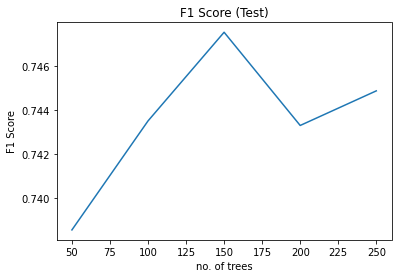

In [38]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('no. of trees')
plt.ylabel('F1 Score')
plt.show()

In [39]:
print(bestF1Avg)

0.7475211568992657


### Glove:

In [21]:
bestF1Avg = 0
bestComb = {}
f1s = []
n_estims = [50, 100, 150, 200, 250]
for estim in n_estims:
    print("Boosting rounds:", estim)
    avgF1 = 0
    comb = {}
    for t in targets:
        xgbClf = XGBClassifier(use_label_encoder=False, random_state=0, eval_metric='mlogloss', n_estimators=estim)
        X_train, X_test, y_train, y_test = train_test_split(np.array(X_glove), df[t], test_size=0.3, random_state=0)
        xgbClf.fit(X_train, y_train)
        y_pred = xgbClf.predict(X_test)
        print(t, " F1 Score -> ", f1_score(y_test, y_pred), " Accuracy Score -> ", accuracy_score(y_test, y_pred))
        avgF1 += f1_score(y_test, y_pred)
        comb[t] = xgbClf
    avgF1 /= 4
    f1s.append(avgF1)
    if avgF1 > bestF1Avg:
        bestF1Avg = avgF1
        bestComb = comb
    print("\n")

Boosting rounds: 50
IvsE  F1 Score ->  0.8626560726447219  Accuracy Score ->  0.7675758739915483
NvsS  F1 Score ->  0.9252550489277536  Accuracy Score ->  0.8620822128313484
TvsF  F1 Score ->  0.696315120711563  Accuracy Score ->  0.7245485977718018
JvsP  F1 Score ->  0.4519337016574586  Accuracy Score ->  0.6189012677679601


Boosting rounds: 100
IvsE  F1 Score ->  0.8633484162895927  Accuracy Score ->  0.767960046100653
NvsS  F1 Score ->  0.9275181723779855  Accuracy Score ->  0.8659239339223972
TvsF  F1 Score ->  0.7029535864978903  Accuracy Score ->  0.7295428351901652
JvsP  F1 Score ->  0.45925110132158586  Accuracy Score ->  0.6227429888590088


Boosting rounds: 150
IvsE  F1 Score ->  0.8645833333333334  Accuracy Score ->  0.7702650787552824
NvsS  F1 Score ->  0.9287938550965331  Accuracy Score ->  0.8682289665770265
TvsF  F1 Score ->  0.7071217867678045  Accuracy Score ->  0.7330003841721091
JvsP  F1 Score ->  0.46213808463251677  Accuracy Score ->  0.6288897426046869


Boosting

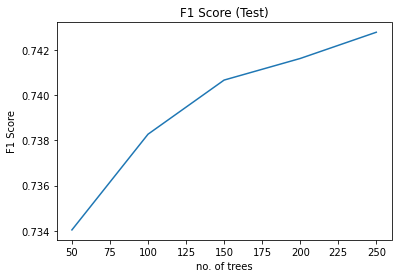

In [22]:
plt.title("F1 Score (Test)")
plt.plot(n_estims, f1s)
plt.xlabel('no. of trees')
plt.ylabel('F1 Score')
plt.show()

In [24]:
print(bestF1Avg)

0.7427722699649394
